In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scperturb
from SERGIO._perturbation import perturbation


create perturbation object

In [19]:
pert.wt.shape[-1]

1000

In [11]:
pert = perturbation()
pert.create(20)
%time pert.perturbation_all(nCells=1000)

KeyboardInterrupt: 

In [3]:
pert.save('pert_15_100')

load previously created perturbation object

In [10]:
pert = perturbation().load('pert_34_1000')

In [4]:
G = pert.G
store = pert.store
wt = pert.wt
grn = pert.grn0

In [5]:
store.shape,wt.shape
gene_list = list(grn.attr_['genes'].keys())

inspect those genes.
The second gene in the tuple is known to have in-degree 1

In [6]:
[([*G.predecessors(k)][0],k) for k,v in dict(G.in_degree()).items() if v ==1]


[('11', '3'), ('13', '7'), ('7', '12'), ('12', '10'), ('14', '13')]

In [23]:
store.shape


[]

draw network containing 'gene_view', its successors and they other parents

11


,from,to,weight
0,11,2,-2.182360
1,11,3,2.303306
2,11,8,2.837185


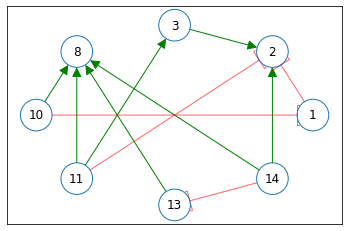

In [7]:
gene_view = '11'#gene_list[1]

print(gene_view)


two_step_neigh = {*itertools.chain.from_iterable([set(G.predecessors(g)) for g in set(G.successors(gene_view))])}
#plt.figure(figsize=(8,8))
pert.draw_net(G.subgraph(two_step_neigh.union(G.successors(gene_view)).union({gene_view})))
pd.DataFrame([[a,b,d['weight']] for a,b,d in list(G.out_edges(gene_view,data=True))],columns=[['from','to','weight']])

In [107]:
5/0.8

6.25

Investigate expression on the target gene

<AxesSubplot:ylabel='Density'>

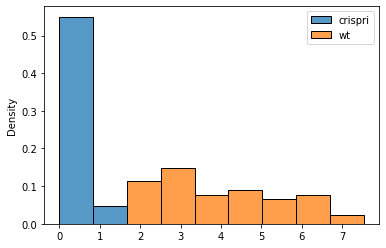

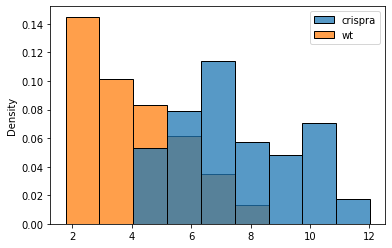

In [8]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
#j = np.arange(len(gene_list))[np.array(gene_list)==list(G.out_edges(gene_view))[0][1]][0]#take the index of one of the genes neighbouring gene_view
j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


investigate on direct neighbours

<AxesSubplot:ylabel='Density'>

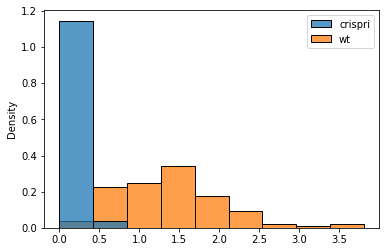

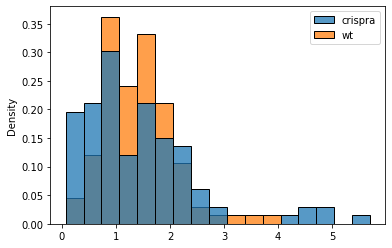

In [9]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
j = np.arange(len(gene_list))[np.array(gene_list)=='3'][0]#take the index of one of the genes neighbouring gene_view
#j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


In [23]:
pd.DataFrame(G.in_edges('9',data = True))


['2', '7', '8', '1', '15', '21', '18']

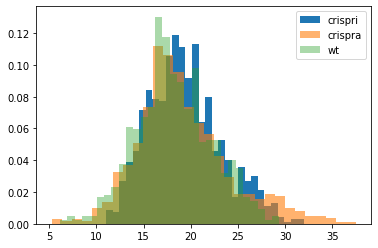

In [38]:
h,b,_ = plt.hist(store[0,i,j],bins =30,label = 'crispri',density = True)

h,b,_ = plt.hist(store[1,i,j],alpha = 0.6,bins = 30,label = 'crispra',density = True)
h,b,_ = plt.hist(wt[j],alpha = 0.4,bins = 30,label = 'wt',density = True)
plt.legend()

In [164]:
pd.DataFrame([[i,v.prod_rates_[0]] for i,v in sim2.grn_.attr_['genes'].items()if v.prod_rates_ is not None] ,columns= ['MR_id','prod_rate'])

,MR_id,prod_rate
0,2737,3.582154
1,4853,4.081881
2,900,5.000000
3,7161,1.538699
4,3135,2.003430
5,3164,1.158086
6,9572,2.282716
7,5598,1.877689
8,5602,4.718141
9,50674,2.268740


In [129]:
sim2.grn_.attr_['genes'][gene]._calc_prod([0], regs_conc = 'sim')
sim2.grn_.attr_['genes'][gene].prod_rates_

array([5.])

In [13]:
sim2.grn_.attr_['genes'][gene].isMR_,sim.grn_.attr_['genes'][gene].isMR_


(True, False)

In [30]:
if sim2.grn_.attr_['genes'][list(non_mr)[0]].prod_rates_ is not None:
    print('None')

None


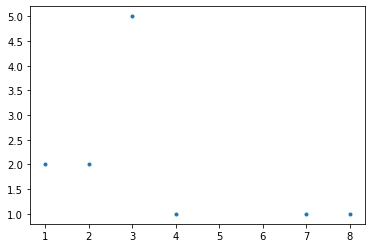

In [156]:
sim2.grn_.attr_['genes'][gene].level,
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in mrs ]).items())),'.')


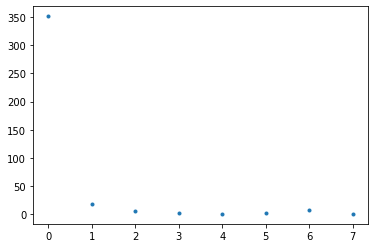

In [159]:
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in non_mr if el!=gene]).items())),'.')


run etest on Anndata, create a unique anndata with perturbation column. Use p-values to compare with experiments

In [44]:
import scanpy as sc
scperturb.edist_to_control


In [42]:
def edist_to_control(adata, obs_key='perturbation', control='control', 
                     obsm_key='X_pca', dist='sqeuclidean',  
                     flavor=0, verbose=True):
    """Computes the edistance to control.
    Computes the all E-distances between all groups of cells defined in
    adata.obs[obs_key] (e.g. perturbations) and control cells. Distances are computed in embedding
    space given by adata.obsm[obsm_key] (e.g. PCA space).
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    obs_key: `str` in adata.obs.keys() (default: `perturbation`)
        Key in adata.obs specifying the groups to consider.
    obsm_key: `str` in adata.obsm (default: `adata.obsm['X_pca']`)
        Key for embedding coordinates to use.
    dist: `str` for any distance in scipy.spatial.distance (default: `sqeuclidean`)
        Distance metric to use in embedding space.
    flavor: `int` (default: `0`)
        Which flavor of E-distance to use.
        - `0`: E-distance no correction factor
        - `1`: E-distance with simple correction factor (N-1)
        - `2`: E-distance with correction factor NM/(N+M)
        - `3`: E-distance with correction division by delta
    verbose: `bool` (default: `True`)
        Whether to show a progress bar iterating over all groups.
    Returns
    -------
    ed_to_c: pandas.DataFrame
        DataFrame with E-distances between all groups and control group.
    """
    correction_factor = flavor==1
    deltas_to_c = onesided_pca_distances(adata, obs_key=obs_key, control=control, 
                                         obsm_key=obsm_key, dist=dist, 
                                         correction_factor=correction_factor, 
                                         verbose=verbose)
    sigmas = self_pca_distances(adata, obs_key, obsm_key=obsm_key, dist=dist, 
                                correction_factor=correction_factor, verbose=False)
    # derive basic statistics
    ed_to_c = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    if flavor == 2:
        sizes = np.array([np.sum(adata.obs[obs_key]==g) for g in sigmas.index])
        corrections = (sizes * sizes[sigmas.index==control]) / (sizes + sizes[sigmas.index==control])
        ed_to_c = ed_to_c * corrections.reshape(-1,1)
    if flavor == 3:
        ed_to_c = ed_to_c / deltas_to_c
    return ed_to_c

In [2]:
pert = perturbation(50)
pert.perturbation_all(nCells=10)

/home/giuseppe/Documents/Sergio_perturbation/SERGIO/_perturbation.py:157: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  J = nx.adjacency_matrix(G)
DEBUG:root:Number of nodes is 33


KeyboardInterrupt: 

In [3]:
pert.save('pert_10')

In [7]:
import pickle
pickle.dump?

In [4]:
pert.load('pert_10')

In [5]:
pert.store

array([[[[0.00000000e+00, 1.07644500e-01, 2.00254368e-01,
          3.15047724e-02, 0.00000000e+00, 9.91562830e-02,
          2.00254368e-01, 1.52326733e-01, 1.45232398e-01,
          2.12374233e-01],
         [3.87152751e+00, 3.82110445e+00, 4.20384171e+00,
          2.72978465e+00, 4.14533028e+00, 3.66240337e+00,
          4.20384171e+00, 3.49483939e+00, 4.19844366e+00,
          3.17552036e+00],
         [7.19312223e+00, 8.16663076e+00, 8.28894991e+00,
          7.67124380e+00, 8.02660001e+00, 7.51668214e+00,
          8.28894991e+00, 6.31544570e+00, 8.52381962e+00,
          6.26944109e+00],
         [1.27698252e-01, 4.37413958e-01, 1.01735568e-01,
          6.53540987e-02, 5.10127547e-01, 6.07956638e-01,
          1.01735568e-01, 5.91108159e-01, 7.41290822e-02,
          6.32171083e-01],
         [1.58445139e+00, 1.08792231e+00, 1.22927771e+00,
          1.53669167e+00, 1.52341030e+00, 7.96520363e-01,
          1.22927771e+00, 9.10082770e-01, 1.46160539e+00,
          9.54253707e-